# library importing

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import sklearn
import random
from unicodedata import normalize
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

https://m.blog.naver.com/PostView.nhn?blogId=sexyit_2019&logNo=221603292906&proxyReferer=https:%2F%2Fwww.google.com%2F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Ready for Data

In [ ]:
# 오디오 데이터
DATA_DIR = '/content/drive/My Drive/졸프/0726Data/'

In [ ]:
# Example : train폴더의 음성파일 접근
wav, sr = librosa.load(DATA_DIR + '/train2/음100.wav', sr=16000)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (3874,)
length: 0.242125 secs


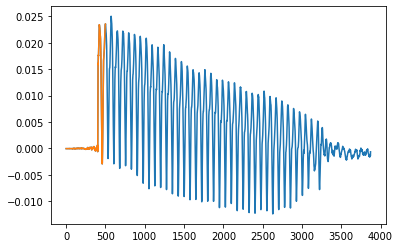

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
# Data set list, include (raw data, mfcc data, y data)
trainset = []
testset = []

# split each set into raw data, mfcc data, and y data
# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것
train_X = []
train_mfccs = []
train_y = []

test_X = []
test_mfccs = []
test_y = []

# 모든 음성파일의 길이가 같도록 후위에 padding 처리
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

frame_length = 0.025
frame_stride = 0.0010

In [ ]:
# train data를 넣는다.
for filename in os.listdir(DATA_DIR + "train2/"):
  filename = normalize('NFC', filename)
  try:
    # wav 포맷 데이터만 사용
    if '.wav' not in filename in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR+ "train2/"+ filename, sr=16000)
    
    mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 40)

    # 추임새 별로 dataset에 추가
    if filename[0] == '어':
      trainset.append((padded_mfcc, 0))
    elif filename[0] == '음':
      trainset.append((padded_mfcc, 1))
    elif filename[0] == '그':
      trainset.append((padded_mfcc, 2))
  except Exception as e:
    print(filename, e)
    raise

# 학습 데이터를 무작위로 섞는다.
random.shuffle(trainset)

In [ ]:
# test data를 넣는다.
for filename in os.listdir(DATA_DIR + "test2/"):
  filename = normalize('NFC', filename)
  try:
    # wav 포맷 데이터만 사용
    if '.wav' not in filename in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR+ "test2/"+ filename, sr=16000)

    mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 40)

    # 추임새 별로 test dataset에 추가
    if filename[0] == '어':
      testset.append((padded_mfcc, 0))
    elif filename[0] == '음':
      testset.append((padded_mfcc, 1))
    elif filename[0] == '그':
      testset.append((padded_mfcc, 2))
  except Exception as e:
    print(filename, e)
    raise

# 평가 데이터를 무작위로 섞는다.
random.shuffle(testset)

In [ ]:
train_mfccs = [a for (a,b) in trainset]
train_y = [b for (a,b) in trainset]

test_mfccs = [a for (a,b) in testset]
test_y = [b for (a,b) in testset]

train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)


train_mfccs: (2033, 100, 40)
train_y: (2033, 3)
test_mfccs: (150, 100, 40)
test_y: (150, 3)


# MFCC feature로 학습

In [ ]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (2033, 100, 40, 1)
test X shape: (150, 100, 40, 1)


In [ ]:
ip = Input(shape=train_X_ex[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*3, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(64, activation='relu')(m)

m = Dense(32, activation='relu')(m)

op = Dense(3, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 40, 1)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 37, 96)        1632      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 9, 96)         0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1327168   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/100
64/64 [==============================] - 8s 121ms/step - loss: 1.2930 - accuracy: 0.4019 - val_loss: 0.9926 - val_accuracy: 0.5800
Epoch 2/100
64/64 [==============================] - 8s 118ms/step - loss: 0.9506 - accuracy: 0.5347 - val_loss: 0.8784 - val_accuracy: 0.5933
Epoch 3/100
64/64 [==============================] - 7s 117ms/step - loss: 0.8126 - accuracy: 0.6508 - val_loss: 0.7978 - val_accuracy: 0.6600
Epoch 4/100
64/64 [==============================] - 7s 117ms/step - loss: 0.7450 - accuracy: 0.6842 - val_loss: 0.7555 - val_accuracy: 0.6467
Epoch 5/100
64/64 [==============================] - 7s 116ms/step - loss: 0.6855 - accuracy: 0.7049 - val_loss: 0.7964 - val_accuracy: 0.6133
Epoch 6/100
64/64 [==============================] - 8s 130ms/step - loss: 0.5293 - accuracy: 0.8018 - val_loss: 0.7664 - val_accuracy: 0.6600
Epoch 7/100
64/64 [==============================] - 7s 117ms/step - loss: 0.4971 - accuracy: 0.8082 - val_loss: 0.9864 - val_accuracy: 0.5467

In [ ]:
model.save('/content/drive/My Drive/졸프/0726Data/filler_classifier_by_train2_1215.h5')

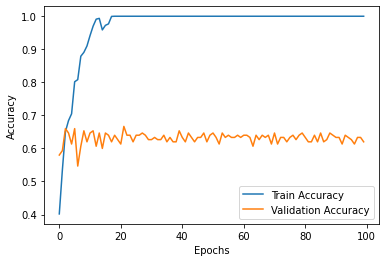

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# 샘플 오디오 데이터
DATA_DIR = '/content/drive/My Drive/졸프/'

wav, sr = librosa.load(DATA_DIR + 'sample.m4a', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 44100
wav shape: (1651712,)
length: 37.45378684807256 secs


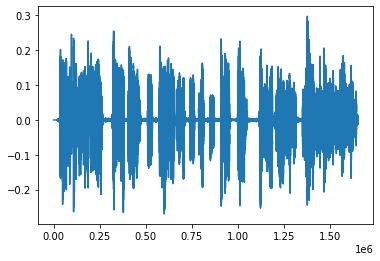

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
audio, sr = librosa.load('/content/그603.wav')
mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 40)
padded_mfcc= np.expand_dims(padded_mfcc, 0)

In [ ]:
model.predict(padded_mfcc)

array([[2.0519461e-14, 1.7445679e-08, 1.0000000e+00]], dtype=float32)